In [1]:
import numpy as np

datasets = np.load('npz/ObjectDetection.npz', allow_pickle=True)
images, numbers, bboxes = datasets['images'], datasets['numbers'], datasets['bboxes']

print(images.shape, numbers.shape, bboxes.shape)
print(images.max(), images.min())
print(bboxes[:3])

(13276, 24, 32) (13276,) (13276, 4, 4)
255 0
[[[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]]


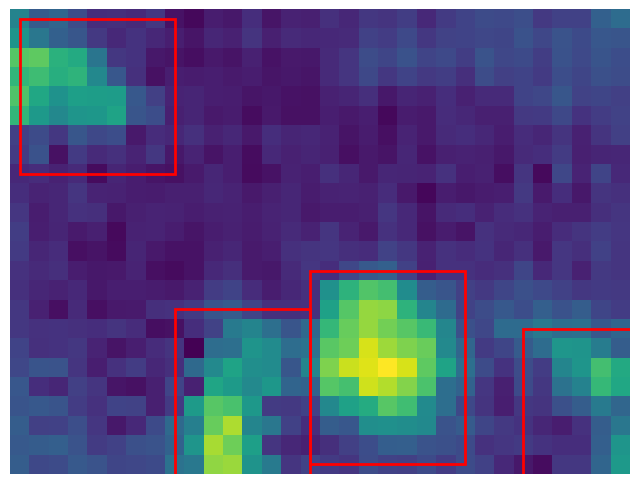

In [2]:
import matplotlib.pyplot as plt

boxes = bboxes[9000]
plt.figure(figsize = (8, 8))
plt.axis('off')
plt.imshow(images[9000])
ax = plt.gca()

for box in boxes:
	xmin, ymin = box[:2]
	w, h = box[2:] - box[:2]
	patch = plt.Rectangle(
		[xmin, ymin], w, h, fill = False, edgecolor = [1, 0, 0], linewidth = 2
	)
	ax.add_patch(patch)
plt.show()

In [3]:
import os
import random
import tensorflow as tf

IMG_SIZE_WIDTH = images.shape[2]
IMG_SIZE_HEIGHT = images.shape[1]
N_DATA = images.shape[0]
N_TRAIN = int(images.shape[0] * 0.7)
N_VAL = images.shape[0] - N_TRAIN
LOG_DIR = 'ObjectDetectionLog'

print("IMG_SIZE_WIDTH:  ", IMG_SIZE_WIDTH)
print("IMG_SIZE_HEIGHT: ", IMG_SIZE_HEIGHT)
print("N_DATA:          ", N_DATA)
print("N_TRAIN:         ", N_TRAIN)
print("N_VAL:           ", N_VAL)


shuffle_list = list(range(N_DATA))
random.shuffle(shuffle_list)

train_idx_list = shuffle_list[:N_TRAIN]
val_idx_list = shuffle_list[N_TRAIN:]

cur_dir = os.getcwd()
tfr_dir = os.path.join(cur_dir, 'tfrecord/ObjectDetection')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'od_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'od_val.tfr')

writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)


2024-01-10 12:13:07.720935: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-10 12:13:07.767036: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-10 12:13:08.520499: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


IMG_SIZE_WIDTH:   32
IMG_SIZE_HEIGHT:  24
N_DATA:           13276
N_TRAIN:          9293
N_VAL:            3983


In [4]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))

def _float_feature(value):
    return tf.train.Feature(float_list = tf.train.FloatList(value = value))

def _int64_feature(value):
    return tf.train.Feature(int64_list = tf.train.Int64List(value = [value]))

In [5]:
for idx in train_idx_list:
    bbox = bboxes[idx]
    xmin, ymin, xmax, ymax = bbox[:, 0], bbox[:, 1], bbox[:, 2], bbox[:, 3]

    xmin = xmin / IMG_SIZE_WIDTH
    ymin = ymin / IMG_SIZE_HEIGHT
    xmax = xmax / IMG_SIZE_WIDTH
    ymax = ymax / IMG_SIZE_HEIGHT

    bbox = np.stack([xmin, ymin, xmax, ymax], axis=-1).flatten()

    image = images[idx]
    bimage = image.tobytes()

    number = numbers[idx]
    label = 1 if number != 0 else 0    
    
    example = tf.train.Example(features = tf.train.Features(feature = {
        'image': _bytes_feature(bimage),
        'bbox': _float_feature(bbox),
        'count': _int64_feature(number),
        'label':_int64_feature(label)
    }))
    
    writer_train.write(example.SerializeToString())
writer_train.close()


2024-01-10 12:13:13.780944: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 870 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1d:00.0, compute capability: 8.6
2024-01-10 12:13:13.783034: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21853 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1f:00.0, compute capability: 8.6
2024-01-10 12:13:13.784582: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 21853 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:20:00.0, compute capability: 8.6
2024-01-10 12:13:13.786115: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 21853 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090, 

In [31]:
for idx in val_idx_list:
    bbox = bboxes[idx]
    xmin, ymin, xmax, ymax = bbox[:, 0], bbox[:, 1], bbox[:, 2], bbox[:, 3]

    xmin = xmin / IMG_SIZE_WIDTH
    ymin = ymin / IMG_SIZE_HEIGHT
    xmax = xmax / IMG_SIZE_WIDTH
    ymax = ymax / IMG_SIZE_HEIGHT

    bbox = np.stack([xmin, ymin, xmax, ymax], axis=-1).flatten()

    image = images[idx]
    bimage = image.tobytes()

    number = numbers[idx]
    label = 1 if number != 0 else 0    
    
    example = tf.train.Example(features = tf.train.Features(feature = {
        'image': _bytes_feature(bimage),
        'bbox': _float_feature(bbox),
        'count': _int64_feature(number),
        'label':_int64_feature(label)
    }))
    
    writer_val.write(example.SerializeToString())
writer_val.close()


In [47]:
AUTOTUNE = tf.data.AUTOTUNE

RES_HEIGHT =24
RES_WIDTH = 32
N_EPOCHS = 100
N_BATCH = 8
LR = 0.0005


def _parse_function(tfrecord_serialized):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'bbox': tf.io.VarLenFeature(tf.float32),  # VarLenFeature로 변경
        'count': tf.io.FixedLenFeature([], tf.int64),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }

    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)

    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [RES_HEIGHT, RES_WIDTH, 1])
    image = tf.cast(image, tf.float32) / 255.0

    bbox = tf.sparse.to_dense(parsed_features['bbox'])  # 변환 필요
    bbox = tf.cast(bbox, tf.float32)
    num_boxes = tf.shape(bbox)[0] // 4
    bbox = tf.reshape(bbox, [num_boxes, 4])

    count = tf.cast(parsed_features['count'], tf.int64)
    label = tf.cast(parsed_features['label'], tf.int64)

    return image, bbox, count, label


train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(AUTOTUNE).batch(N_BATCH, drop_remainder=True)

val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=AUTOTUNE).batch(N_BATCH, drop_remainder=True)


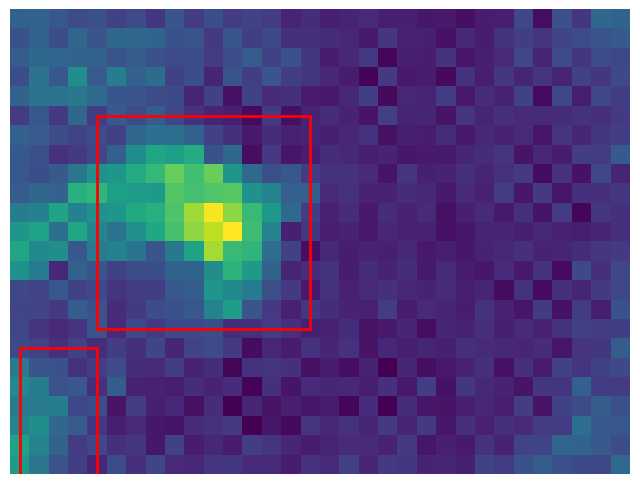

tf.Tensor(2, shape=(), dtype=int64) tf.Tensor(1, shape=(), dtype=int64)


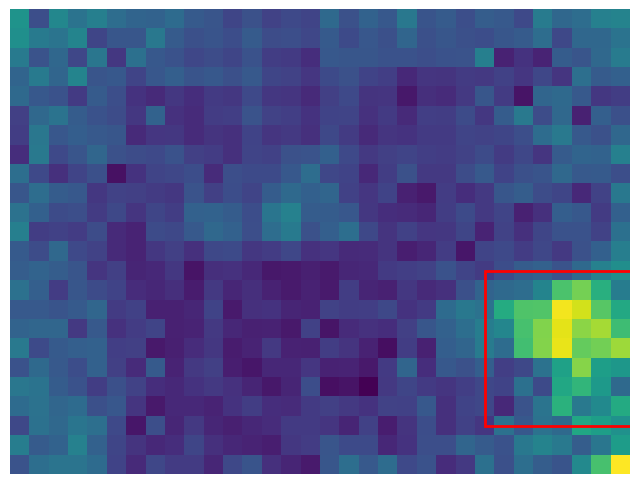

tf.Tensor(1, shape=(), dtype=int64) tf.Tensor(1, shape=(), dtype=int64)


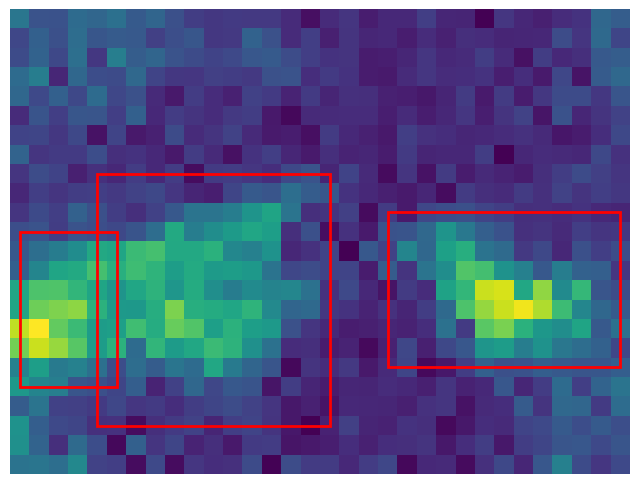

tf.Tensor(3, shape=(), dtype=int64) tf.Tensor(1, shape=(), dtype=int64)


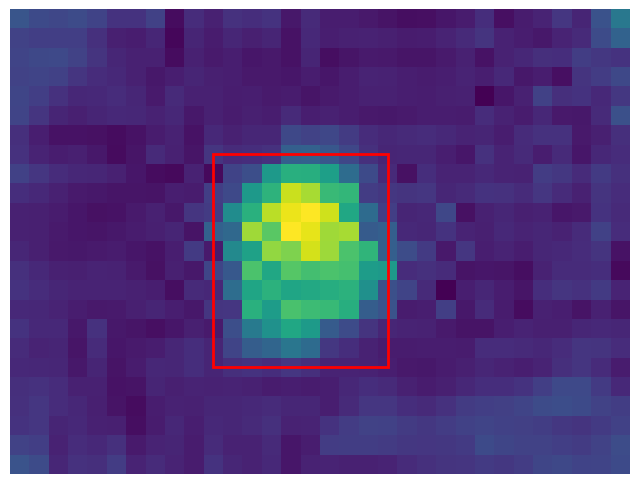

tf.Tensor(1, shape=(), dtype=int64) tf.Tensor(1, shape=(), dtype=int64)


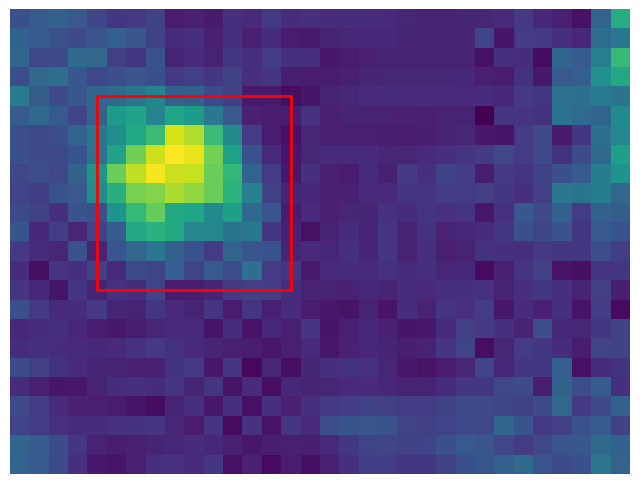

tf.Tensor(1, shape=(), dtype=int64) tf.Tensor(1, shape=(), dtype=int64)


In [49]:
import matplotlib.pyplot as plt

for image, bbox, count, label in val_dataset.take(5):
    image = image[0].numpy()
    bbox = bbox[0]
    count = count[0]
    label = label[0]

    plt.figure(figsize = (8, 8))
    plt.axis('off')
    plt.imshow(image)
    ax = plt.gca()  

    image_h = image.shape[0]    
    image_w = image.shape[1]

    boxes = tf.stack(
    	[
    	 bbox[:, 0] * image_w,
    	 bbox[:, 1] * image_h,
    	 bbox[:, 2] * image_w,
    	 bbox[:, 3] * image_h
    	], axis = -1
    )

    for box in boxes:
        xmin, ymin = box[:2]
        w, h = box[2:] - box[:2]
        patch = plt.Rectangle(
            [xmin, ymin], w, h, fill = False, edgecolor = [1, 0, 0], linewidth = 2
        )
        ax.add_patch(patch)
    plt.show()
    print(count, label)
